In [1]:
import warnings
warnings.filterwarnings("ignore")

### Hyper-parameter tuning

This week, we will learn how to optimize the parameters of the model to achieve the best performance.

<div class="alert alert-info">Step 1: Read the dataset.</div>

In [2]:
import numpy as np
import pandas as pd
df = pd.read_csv("https://raw.githubusercontent.com/gnapoles/data-mining-course/main/diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
# Defining features and targets
X = df.drop(columns=["Outcome"])
y = df["Outcome"]
print(X.shape, y.shape)

(768, 8) (768,)


<div class="alert alert-info">Train a base classifier using holdout.</div>

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
rf = RandomForestClassifier(random_state=42).fit(X_train, y_train)
y_pred = rf.predict(X_test)

rf_acc = accuracy_score(y_test, y_pred)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.85      0.82       100
           1       0.68      0.59      0.63        54

    accuracy                           0.76       154
   macro avg       0.74      0.72      0.73       154
weighted avg       0.75      0.76      0.76       154



<div class="alert alert-info">Train a base classifier using cross validation.</div>

In [6]:
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate

# Start measuring time
start_time = time.time()

# Cross validation and performance evaluation
cv_results = cross_validate(RandomForestClassifier(random_state=42), X, y, cv=5)
test_scores = cv_results['test_score']
print(test_scores)
ave_score = sum(test_scores) / len(test_scores)
print('Baseline score: ' + str(round(ave_score, 2)))

# Calculate and print the elapsed time
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")

[0.74025974 0.74675325 0.75974026 0.83660131 0.75163399]
Baseline score: 0.77
Elapsed time: 0.8804843425750732 seconds


<div class="alert alert-warning">Exercise 1: check to manual</div>

### Grid Search

In [7]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define the hyperparameters and their possible values 
param_grid = {'n_estimators': [10, 50, 100],
              'max_features': [None,'sqrt', 'log2'], 'criterion': ['gini','entropy']}

# Create the model you want to tune
model = RandomForestClassifier(random_state=42)

# Create a grid search object
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)

# Fit the grid search to your data
grid_search.fit(X, y)  # Replace X and y with your data

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)
print("Best performance:", grid_search.best_score_)


Best Hyperparameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 50}
Best performance: 0.774755962991257


In [8]:
#Visualizisation Block
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
#seaborn version 0.12.1
#print("Seaborn version:", sns.__version__)

def plot_tuning_results(df_val):
    
    df_temp = df_val[:][df_val.max_features != 'sqrt'].sort_values(by=['n_estimators', 'criterion'])
    df_none = df_temp[:][df_temp.max_features != 'log2'].sort_values(by=['n_estimators', 'criterion'])
    df_sqrt = df_val[:][df_val.max_features == 'sqrt'].sort_values(by=['n_estimators', 'criterion'])
    df_log2 = df_val[:][df_val.max_features == 'log2'].sort_values(by=['n_estimators', 'criterion'])

    pivot1 = df_none.pivot_table(index='n_estimators',columns='criterion',values='accuracy')
    pivot2 = df_sqrt.pivot_table(index='n_estimators',columns='criterion',values='accuracy')
    pivot3 = df_log2.pivot_table(index='n_estimators',columns='criterion',values='accuracy')
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,4))

    sns.heatmap(pivot1,vmin=0.45,vmax=0.65,annot=True,linewidths=0.4,ax=ax1,cmap="coolwarm_r")
    sns.heatmap(pivot2,vmin=0.45,vmax=0.65,annot=True,linewidths=0.4,ax=ax2,cmap="coolwarm_r")
    sns.heatmap(pivot3,vmin=0.45,vmax=0.65,annot=True,linewidths=0.4,ax=ax3,cmap="coolwarm_r")
    
    ax1.set_title("max_features: none")
    ax3.set_title("max_features: log2")
    ax2.set_title("max_features: sqrt")

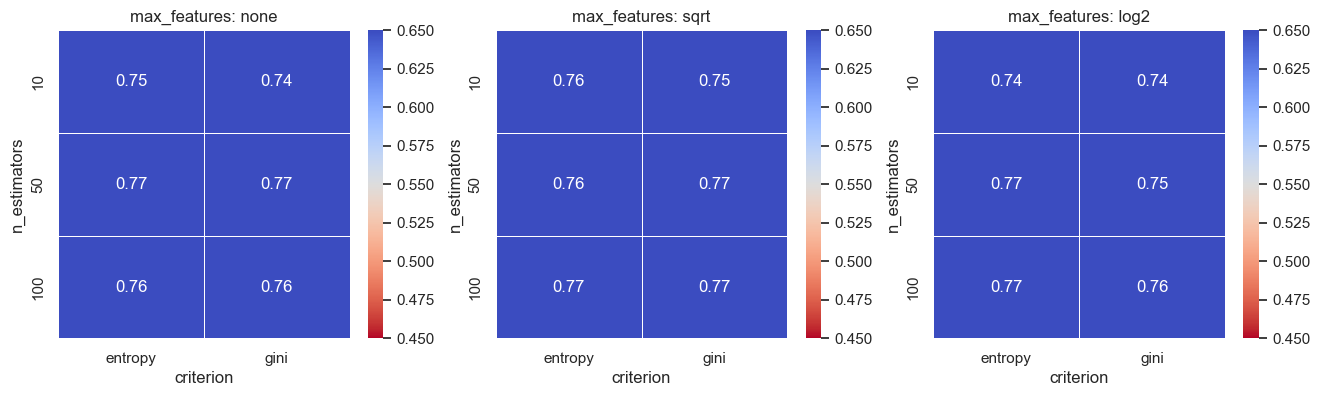

In [9]:
df_grid = pd.DataFrame(grid_search.cv_results_["params"])
df_grid['accuracy'] = np.round(grid_search.cv_results_["mean_test_score"],2)
plot_tuning_results(df_grid)

<div class="alert alert-warning"> Exercise 2:check the manual</div>

### Random Search

In [14]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Define the hyperparameter grid
param_dist = {'n_estimators': [10, 50, 100], 
              'max_features': [None,'sqrt', 'log2'], 'criterion': ['gini','entropy']}
# Create a Random Forest classifier
model= RandomForestClassifier(random_state=42)

# Create a RandomizedSearchCV object
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=8,  # Number of random combinations to try
    cv=5,         # Number of cross-validation folds
)

# Fit the RandomizedSearchCV to your data
random_search.fit(X, y)

# Print the best hyperparameters found by Random Search
print("Best Hyperparameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)
random_search.best_score_


Best Hyperparameters: {'n_estimators': 50, 'max_features': 'sqrt', 'criterion': 'gini'}
Best Score: 0.774755962991257


0.774755962991257

<div class="alert alert-info">Step 4: Comparing their performance.</div>

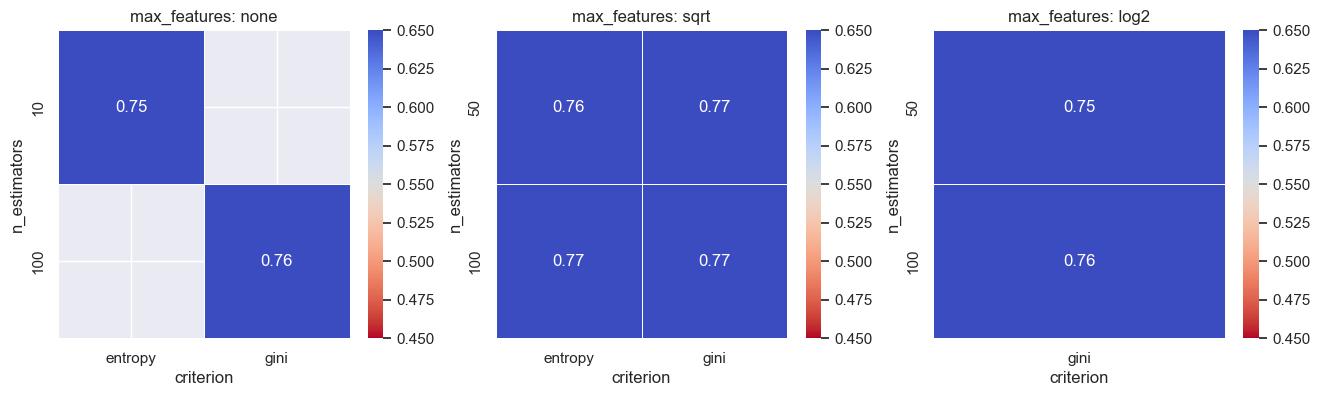

In [15]:
df_random = pd.DataFrame(random_search.cv_results_["params"])
df_random['accuracy'] = np.round(random_search.cv_results_["mean_test_score"],2)
plot_tuning_results(df_random)

<div class="alert alert-warning">Practice with student dataset</div>

In [16]:
df = pd.read_csv('student_exam_data.csv')
X = df.drop(columns=["Pass/Fail"])
y = df["Pass/Fail"]

<div class="alert alert-warning">Exercise 3:As a data scientist, you are tasked to optimize the parameter of a KNN model with all possible combinations of odd values for k (k<12) and uniform and dictance weighting measures. Which of the following snippets will assist you in achieving this goal?</div> 

In [18]:
#a)
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import RandomForestClassifier
# Define the hyperparameters and their possible values 
param_grid={'n_neighbors': [1,3,5, 7, 8, 9,11],
                         'weights': ['uniform', 'distance']}

model= RandomForestClassifier()

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)

grid_search.fit(X, y)

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)
print("Best performance:", grid_search.best_score_)


ImportError: cannot import name 'RandomForestClassifier' from 'sklearn.neighbors' (c:\Users\marti\anaconda3\Lib\site-packages\sklearn\neighbors\__init__.py)

In [17]:
#b)
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
# Define the hyperparameters and their possible values 
param_grid={'n_neighbors': [1,3,5, 7, 8, 9,11],
                         'weights': ['uniform', 'distance']}

model= RandomForestClassifier()

grid_search =RandomizedSearchCV(estimator=model, param_grid=param_grid, cv=3)

grid_search.fit(X, y)  # Replace X and y with your data

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)
print("Best performance:", grid_search.best_score_)

TypeError: RandomizedSearchCV.__init__() got an unexpected keyword argument 'param_grid'

In [99]:
#c)
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
# Define the hyperparameters and their possible values 
param_grid={'n_neighbors': [1,3,5, 7, 8, 9,11],
                         'weights': ['uniform', 'distance']}

model= KNeighborsClassifier()

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)

grid_search.fit(X, y) 

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)
print("Best performance:", grid_search.best_score_)

Best Hyperparameters: {'n_neighbors': 9, 'weights': 'distance'}
Best performance: 0.983983839549816


In [111]:
#d)
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
# Define the hyperparameters and their possible values 
param_dist={'n_neighbors': [1,3,5, 7, 8, 9,11],
                         'weights': ['uniform', 'distance']}

model= KNeighborsClassifier()

random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=5,  # Number of random combinations to try
    cv=3,         # Number of cross-validation folds
)

random_search.fit(X, y) 

# Print the best hyperparameters
print("Best Hyperparameters:",random_search.best_params_)
print("Best performance:", random_search.best_score_)

Best Hyperparameters: {'weights': 'distance', 'n_neighbors': 9}
Best performance: 0.983983839549816


<div class="alert alert-warning">Exercise 4: Given the outcome of the previous experiment, which of the following settings will lead to lower error?</div> 